## K-Means Clustering

**Overview**<br>
<a href="https://archive.ics.uci.edu/ml/datasets/online+retail">Online retail is a transnational data set</a> which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:
1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# read the dataset
df = pd.read_csv('cleaned_data.csv',index_col=0)
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,time
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,12,2010,08:26:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,08:26:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,12,2010,08:26:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,08:26:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,12,2010,08:26:00


In [3]:
## changing the customer id data type to object
df['CustomerID']= df['CustomerID'].astype('object')

## changing the Invoicedate data type to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])


df['month']= df['month'].astype('object')
df['year']= df['year'].astype('object')
### Total Revenue
df['Total Amount'] = df['UnitPrice'] * df['Quantity']
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     406829 non-null  object        
 1   StockCode     406829 non-null  object        
 2   Description   406829 non-null  object        
 3   Quantity      406829 non-null  int64         
 4   InvoiceDate   406829 non-null  datetime64[ns]
 5   UnitPrice     406829 non-null  float64       
 6   CustomerID    406829 non-null  object        
 7   Country       406829 non-null  object        
 8   month         406829 non-null  object        
 9   year          406829 non-null  object        
 10  time          406829 non-null  object        
 11  Total Amount  406829 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(8)
memory usage: 40.4+ MB


# 2. Prepare the data for modelling

- R (Recency): Number of days since last purchase
- F (Frequency): Number of tracsactions
- M (Monetary): Total amount of transactions (revenue contributed)

In [4]:
# monetary
grouped_df = df.groupby('CustomerID')['Total Amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,Total Amount
0,12346.0,154367.20
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [5]:
# frequency
frequency = df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.columns = ['CustomerID', 'frequency']
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [6]:
# merge the two dfs
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,Total Amount,frequency
0,12346.0,154367.20,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [7]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,time,Total Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,12,2010,08:26:00,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,08:26:00,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,12,2010,08:26:00,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,08:26:00,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,08:26:00,20.34


In [8]:
# compute the max date
max_date = max(df['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [9]:
# compute the diff
df['diff'] = max_date - df['InvoiceDate']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,month,year,time,Total Amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,12,2010,08:26:00,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,08:26:00,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,12,2010,08:26:00,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,08:26:00,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,12,2010,08:26:00,20.34,373 days 04:24:00


In [11]:
# recency
last_purchase = df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [12]:
# merge
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,154367.20,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [13]:
# number of days only
grouped_df['recency'] = grouped_df['recency'].dt.days
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,154367.20,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


{'whiskers': [<matplotlib.lines.Line2D at 0x15880495430>,
 'caps': [<matplotlib.lines.Line2D at 0x15880495a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x158804950d0>],
 'medians': [<matplotlib.lines.Line2D at 0x158804a5190>],
 'fliers': [<matplotlib.lines.Line2D at 0x158804a54f0>],
 'means': []}

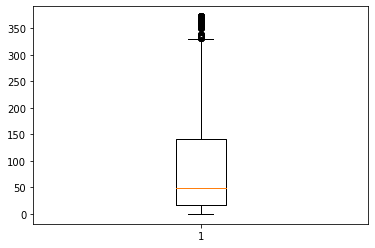

In [14]:
# 1. outlier treatment
plt.boxplot(grouped_df['recency'])

In [15]:
# two types of outliers:
# - statistical
# - domain specific

In [16]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [17]:
# 2. rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4287, 3)

In [18]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,1.617964,1.042924,-0.906582
1,0.250023,-0.463321,-0.183601
2,0.228416,-0.044366,-0.738216
3,-0.546344,-0.602973,2.143802
4,1.158857,0.175087,-0.569851


# 3. Modelling

In [19]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [20]:
kmeans.labels_

array([1, 2, 2, ..., 0, 2, 2])

## Finding the Optimal Number of Clusters

### SSD

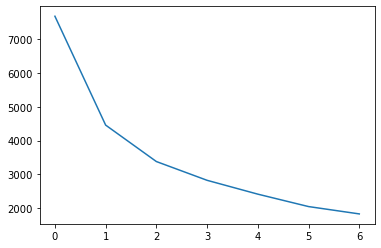

In [22]:
# elbow-curve/SSD
ssd = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

In [23]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5388167013492674
For n_clusters=3, the silhouette score is 0.5082464788762033
For n_clusters=4, the silhouette score is 0.4856516586543141
For n_clusters=5, the silhouette score is 0.4674088012939911
For n_clusters=6, the silhouette score is 0.41588941812316077
For n_clusters=7, the silhouette score is 0.4163096296712399
For n_clusters=8, the silhouette score is 0.4090741272679747


In [24]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [25]:
kmeans.labels_

array([1, 0, 0, ..., 2, 0, 0])

In [26]:
# assign the label
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2
5,12352.0,3466.67,95,35,0


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

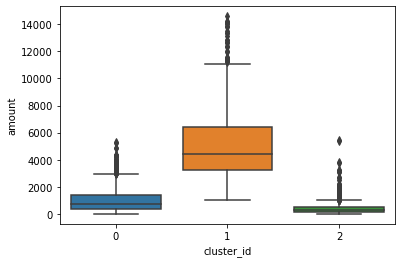

In [27]:
# plot
sns.boxplot(x='cluster_id', y='amount', data=grouped_df)

## Hierarchical Clustering

In [28]:
rfm_df_scaled.head()

,amount,frequency,recency
0,1.617964,1.042924,-0.906582
1,0.250023,-0.463321,-0.183601
2,0.228416,-0.044366,-0.738216
3,-0.546344,-0.602973,2.143802
4,1.158857,0.175087,-0.569851


In [29]:
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2
5,12352.0,3466.67,95,35,0


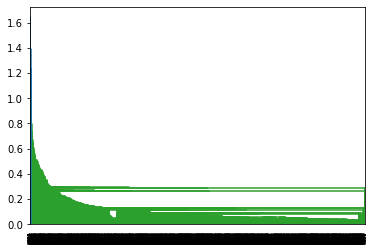

In [30]:
# single linkage
mergings = linkage(rfm_df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

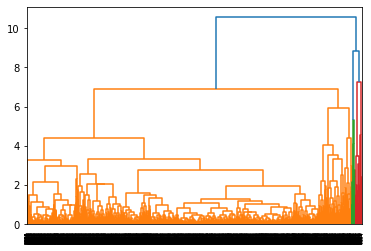

In [31]:
# complete linkage
mergings = linkage(rfm_df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [32]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 0, 0, ..., 0, 0, 0])

In [33]:
# assign cluster labels
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
1,12347.0,4310.00,182,1,1,0
2,12348.0,1797.24,31,74,0,0
3,12349.0,1757.55,73,18,0,0
4,12350.0,334.40,17,309,2,0
5,12352.0,3466.67,95,35,0,0


<AxesSubplot:xlabel='cluster_labels', ylabel='recency'>

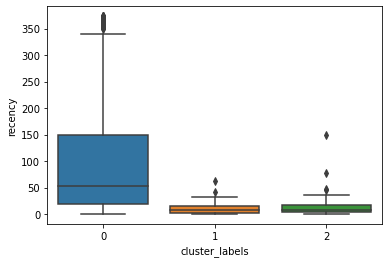

In [34]:
# plots
sns.boxplot(x='cluster_labels', y='recency', data=grouped_df)

<AxesSubplot:xlabel='cluster_labels', ylabel='frequency'>

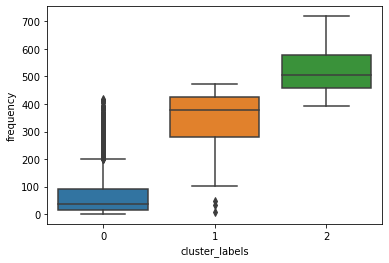

In [35]:
# plots
sns.boxplot(x='cluster_labels', y='frequency', data=grouped_df)

<AxesSubplot:xlabel='cluster_labels', ylabel='amount'>

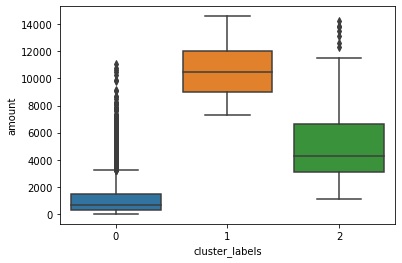

In [36]:
# plots
sns.boxplot(x='cluster_labels', y='amount', data=grouped_df)